In [1]:
import torch
import lightning as pl
from tabulate import tabulate
import matplotlib.pyplot as plt
import torchvision

from kornia import tensor_to_image
from lightning.pytorch.loggers import TensorBoardLogger
from lightning.pytorch import Trainer
from lightning.pytorch.callbacks import EarlyStopping, DeviceStatsMonitor, ModelCheckpoint, LearningRateMonitor
from lightning.pytorch.tuner import Tuner


In [2]:
class Args:
    def __init__(self, config):
        self.lr = config["lr"]
        self.working_dir_path = config["working_dir_path"]
        self.dataset_h5_path = config["dataset_h5_path"]
        self.hospitaldict_path = config["hospitaldict_path"]
        self.rseed = config["rseed"]
        self.train_ratio = config["train_ratio"]
        self.batch_size = config["batch_size"]
        self.freeze_layers = config["freeze_layers"]
        self.optimizer = config["optimizer"]
        self.lr = config["lr"]
        self.weight_decay = config["weight_decay"]
        self.momentum = config["momentum"]
        self.label_smoothing = config["label_smoothing"]
        self.max_epochs = config["max_epochs"]
        self.num_workers = config["num_workers"]
        self.accumulate_grad_batches = config["accumulate_grad_batches"]
        self.precision = config["precision"]
        self.disable_warnings = config["disable_warnings"]
        self.mixup = config["mixup"]
        self.trim_data = config["trim_data"]
        self.pretrained = config["pretrained"]
        self.version = config["version"]

In [3]:
config = {
    "working_dir_path": ".",
    "dataset_h5_path": "/Users/andry/Documents/GitHub/lus-dl-framework/data/iclus/dataset.h5",
    "hospitaldict_path": "/Users/andry/Documents/GitHub/lus-dl-framework/data/iclus/hospitals-patients-dict.pkl",
    "rseed": 42,
    "train_ratio": 0.6,
    "batch_size": 16,
    "freeze_layers": None,
    "optimizer": "sgd",
    "lr": 0.0004,
    "weight_decay": 0.0001,
    "momentum": 0.9,
    "label_smoothing": 0.1,
    "max_epochs": 200,
    "num_workers": 0,
    "accumulate_grad_batches": 4,
    "precision": "32",
    "disable_warnings": True,
    "mixup": True,
    "trim_data": None,
    "pretrained": False,
    "version": "nb"
}

args = Args(config)

In [4]:
pl.seed_everything(args.rseed)

Global seed set to 42


42

In [5]:
if torch.cuda.is_available():
    dev = torch.cuda.get_device_name()
    accelerator = "gpu"
    torch.set_default_tensor_type('torch.cuda.FloatTensor')
    
elif torch.backends.mps.is_built():
    accelerator="mps"
    mps_device = torch.device("mps")
    torch.set_default_device(f"{mps_device}")
else:
    dev = "cpu"

In [6]:
import warnings
if args.disable_warnings: 
    print("Warnings are DISABLED!\n\n")
    warnings.filterwarnings("ignore")
else:
    warnings.filterwarnings("default")

Warnings are DISABLED!




In [7]:
working_dir = args.working_dir_path
data_file = args.dataset_h5_path
libraries_dir = working_dir + "/libraries"

import sys
sys.path.append(working_dir)
sys.path.append("..")
from get_sets import get_sets, get_class_weights
from data_setup import HDF5Dataset, FrameTargetDataset, split_dataset, reduce_sets
from lightning_modules.LUSModelLightningModule import LUSModelLightningModule
from lightning_modules.LUSDataModule import LUSDataModule

# Data

In [16]:

sets, split_info = get_sets(
    args.rseed,
    data_file,
    args.hospitaldict_path,
    args.train_ratio,
    args.trim_data
)

lus_data_module = LUSDataModule(sets["train"], 
                                sets["test"],
                                sets["val"],
                                args.num_workers, 
                                args.batch_size,
                                args.mixup)


train_weight_tensor = get_class_weights(sets["train_indices"], split_info)


Serialized frame index map FOUND.

Loaded serialized data.


277 videos (58924 frames) loaded.
Split ratios: [0.6, 0.2, 0.2]
Train size: 28869, Val size: 15343, Test size: 14712

Serializing splits...

Train size: 28869
Test size: 14712
Validation size: 15343
Class Weights:  [0.76437725 0.89068863 0.79067156 3.28654372]


In [17]:
train_dataloader = lus_data_module.train_dataloader()
train_dataloader

Use MixUp augmentation: True


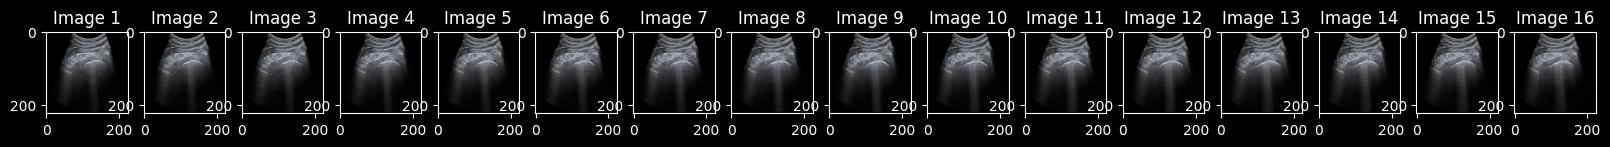

In [18]:
def show_single_batch(data_loader, batch_idx, win_size=(20, 20)):
    # Extract the specific batch by indexing the DataLoader
    for i, (imgs, labels) in enumerate(data_loader):
        if i == batch_idx:
            # Create a subplot for each image in the batch
            num_images = len(imgs)
            plt.figure(figsize=win_size)

            for j in range(num_images):
                plt.subplot(1, num_images, j + 1)
                plt.imshow(tensor_to_image(imgs[j]))  # Convert the tensor to an image
                plt.title(f"Image {j+1}")

            plt.show()
            break
# To display a specific batch (e.g., batch index 0) from the training DataLoader
show_single_batch(train_dataloader, batch_idx=6)

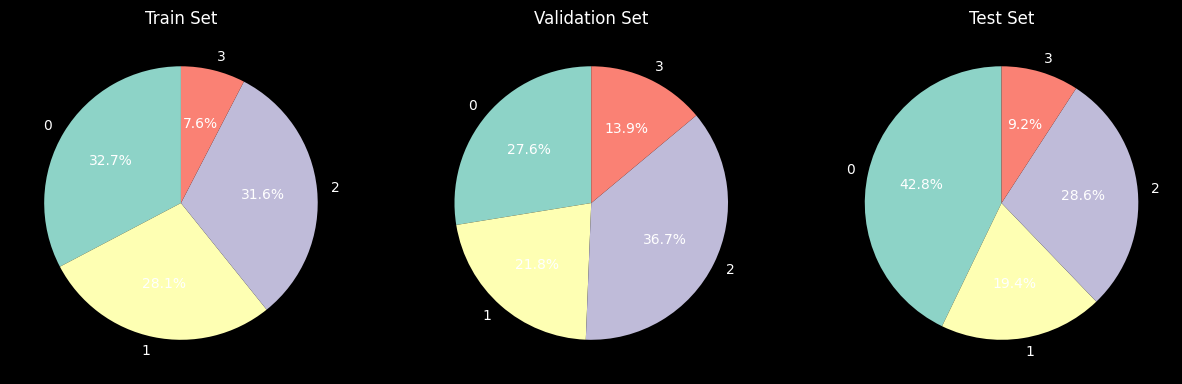

In [20]:
# Assuming you have already retrieved split_info and defined train_indices, val_indices, and test_indices
labels = split_info['labels']

# Extract labels for train, validation, and test sets
train_labels = [labels[i] for i in sets["train_indices"]]
val_labels = [labels[i] for i in sets["val_indices"]]
test_labels = [labels[i] for i in sets["test_indices"]]

# Count the occurrences of each label in each set
train_label_counts = {label: train_labels.count(label) for label in set(train_labels)}
val_label_counts = {label: val_labels.count(label) for label in set(val_labels)}
test_label_counts = {label: test_labels.count(label) for label in set(test_labels)}

# Create pie charts
fig, axes = plt.subplots(1, 3, figsize=(15, 5))

# Train set pie chart
axes[0].pie(train_label_counts.values(), labels=train_label_counts.keys(), autopct='%1.1f%%', startangle=90)
axes[0].set_title('Train Set')

# Validation set pie chart
axes[1].pie(val_label_counts.values(), labels=val_label_counts.keys(), autopct='%1.1f%%', startangle=90)
axes[1].set_title('Validation Set')

# Test set pie chart
axes[2].pie(test_label_counts.values(), labels=test_label_counts.keys(), autopct='%1.1f%%', startangle=90)
axes[2].set_title('Test Set')

plt.show()

# Visualization

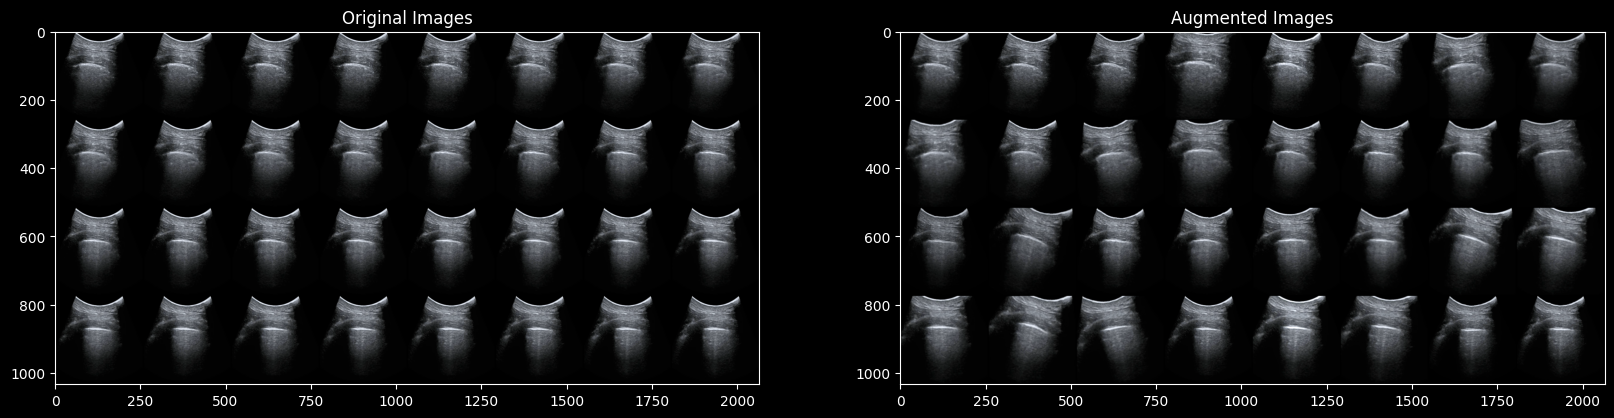

In [54]:

def show_batch(data_loader, num_batches=1, win_size=(20, 20)):
    def _to_vis(data):
        # Ensure that pixel values are in the valid range [0, 1]
        data = torch.clamp(data, 0, 1)
        return tensor_to_image(torchvision.utils.make_grid(data, nrow=8))

    for batch_num, (imgs, labels) in enumerate(data_loader):
        if batch_num >= num_batches:
            break
        
        # Apply data augmentation to the batch (you need to define DataAugmentation function)
        imgs_aug = transform(imgs)

        # Create subplots for original and augmented images
        plt.figure(figsize=win_size)
        plt.subplot(1, 2, 1)
        plt.imshow(_to_vis(imgs))
        plt.title("Original Images")

        plt.subplot(1, 2, 2)
        plt.imshow(_to_vis(imgs_aug))
        plt.title("Augmented Images")

        plt.show()

# To display one batch from the training DataLoader
show_batch(test_dataloader, num_batches=1)

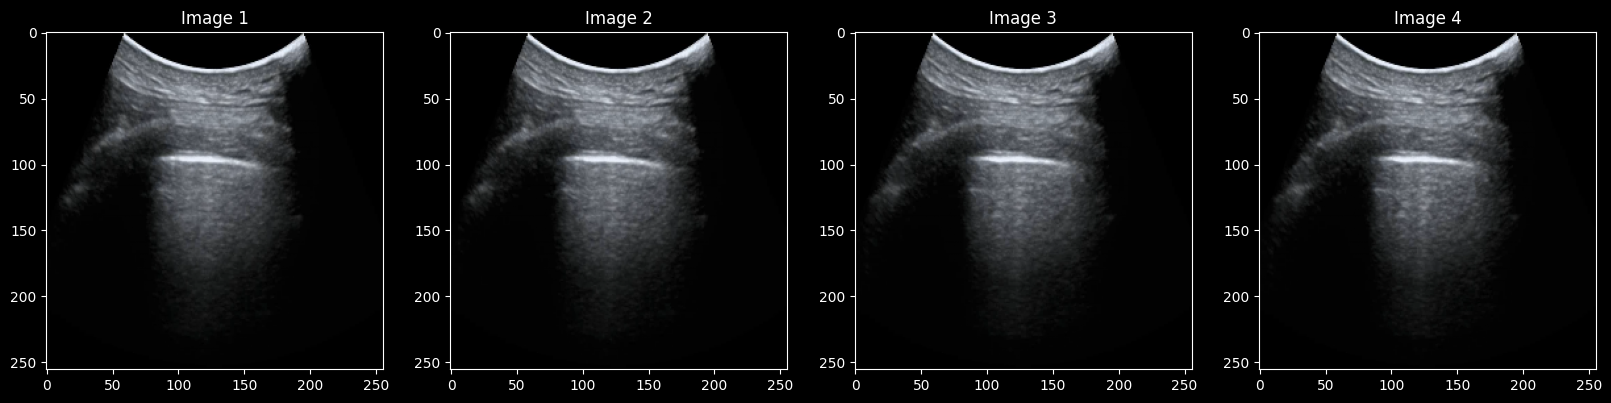

In [18]:
import matplotlib.pyplot as plt
import torchvision

def show_single_batch(data_loader, batch_idx, win_size=(20, 20)):
    # Extract the specific batch by indexing the DataLoader
    for i, (imgs, labels) in enumerate(data_loader):
        if i == batch_idx:
            # Create a subplot for each image in the batch
            num_images = len(imgs)
            plt.figure(figsize=win_size)

            for j in range(num_images):
                plt.subplot(1, num_images, j + 1)
                plt.imshow(tensor_to_image(imgs[j]))  # Convert the tensor to an image
                plt.title(f"Image {j+1}")

            plt.show()
            break
# To display a specific batch (e.g., batch index 0) from the training DataLoader
show_single_batch(test_dataloader, batch_idx=6)


In [ ]:
import matplotlib.pyplot as plt
import numpy as np

def plot_class_distribution(train_indices, test_indices, dataset):
    train_targets = [dataset.__getitem__(index)[2] for index in train_indices]
    test_targets = [dataset.__getitem__(index)[2] for index in test_indices]

    unique_train_targets, train_target_counts = np.unique(train_targets, return_counts=True)
    unique_test_targets, test_target_counts = np.unique(test_targets, return_counts=True)

    # Plot target distribution for the train set
    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    plt.bar(unique_train_targets, train_target_counts, tick_label=unique_train_targets)
    plt.title('Target Distribution (Train Set)')
    plt.xlabel('Target')
    plt.ylabel('Count')

    # Plot target distribution for the test set
    plt.subplot(1, 2, 2)
    plt.bar(unique_test_targets, test_target_counts, tick_label=unique_test_targets)
    plt.title('Target Distribution (Test Set)')
    plt.xlabel('Target')
    plt.ylabel('Count')

    plt.tight_layout()
    plt.show()

# Call this function after splitting the dataset
plot_class_distribution(train_indices, test_indices, dataset)



In [ ]:
len(train_dataset)

10140

In [ ]:
import numpy as np

# Function to calculate class distribution from a dataloader
def calculate_class_distribution(dataloader):
    class_counts = np.zeros(4)  # Assuming you have 4 classes
    for _, labels in dataloader:
        for label in labels:
            class_counts[label] += 1
    return class_counts

# Calculate class distribution for the training and test dataloaders
train_class_distribution = calculate_class_distribution(train_dataloader)
test_class_distribution = calculate_class_distribution(test_dataloader)

# Print the class distribution
print("Training Set Class Distribution:")
for class_idx, count in enumerate(train_class_distribution):
    print(f"Class {class_idx}: {count} samples")

print("\nTest Set Class Distribution:")
for class_idx, count in enumerate(test_class_distribution):
    print(f"Class {class_idx}: {count} samples")


In [ ]:
def mean_std(loader):
  images, lebels = next(iter(loader))
  # shape of images = [b,c,w,h]
  mean, std = images.mean([0,2,3]), images.std([0,2,3])
  return mean, std
mean, std = mean_std(test_dataloader)
print("mean and std: \n", mean, std)